<a href="https://colab.research.google.com/github/dharanitharan24/ChatApp-Project/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.7MYLXT_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.7MYLXT_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

train_dataset = dataset['train'].map(load_image)
test_dataset = dataset['test'].map(load_image)


In [6]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test = test_dataset.batch(BATCH_SIZE)


In [7]:
def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(d4)

    model = models.Model(inputs, outputs, name="U-Net")
    return model

model = build_unet((128, 128, 3))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
EPOCHS = 20
steps_per_epoch = info.splits['train'].num_examples // BATCH_SIZE

model.fit(train, epochs=EPOCHS, steps_per_epoch=steps_per_epoch)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 118s 761ms/step - accuracy: 0.5772 - loss: 0.9830
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 92s 775ms/step - accuracy: 0.5902 - loss: 0.8760
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 774ms/step - accuracy: 0.6955 - loss: 0.7247
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 778ms/step - accuracy: 0.7191 - loss: 0.6625
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 772ms/step - accuracy: 0.6791 - loss: 0.7842
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 772ms/step - accuracy: 0.7169 - loss: 0.6675
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 774ms/step - accuracy: 0.7368 - loss: 0.6226
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 776ms/step - accuracy: 0.7558 - loss: 0.5812
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 778ms/step - accuracy: 0.7811 - loss: 0.5297
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 779ms/step - accuracy: 0.7949 - loss: 0.4974
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 782ms/step - accuracy: 0.8124 - loss: 0.4537
Epoch 12/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4

In [17]:
CLASS_COLOR_MAP = {
    0: [238, 130, 238],  # Violet (Background)
    1: [65, 105, 225],   # Royal Blue (Pet)
    2: [255, 215, 0]     # Gold (Border)
}


In [18]:
def apply_colormap(mask):
    mask = tf.squeeze(mask).numpy()  # shape: (128, 128)
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in CLASS_COLOR_MAP.items():
        color_mask[mask == class_id] = color
    return color_mask


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


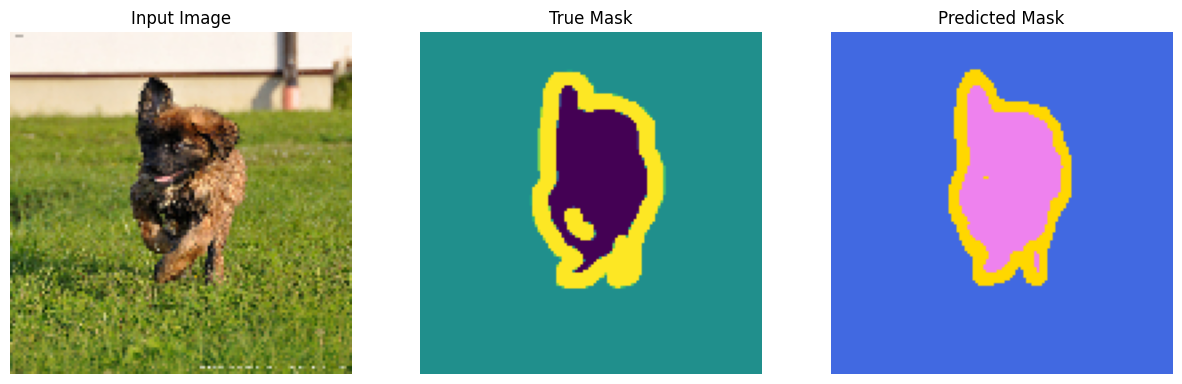

In [19]:
# Predict and display
for image, mask in test.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask[0], axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)

    colored_mask = apply_colormap(pred_mask)

    display([image[0], mask[0], colored_mask])


